### New version

In [5]:
import os
import numpy as np
import pandas as pd
from remote.readers import NumpyVideo
from remote.estimators import HeartRateEstimator, SpO2Estimator

In [2]:
video = NumpyVideo('data/validation/1.mp4')
print(HeartRateEstimator().estimate(video))
print(SpO2Estimator().estimate(video))

(88.40988086831318, True)
(98.60696123480118, True)


In [2]:
meta = pd.read_csv('data/validation/meta.csv')

bpms = []
bpm_valid = []
spo2s = []
spo2_valid = []
for file in meta.file:
    vid = NumpyVideo(os.path.join('data/validation/', file))
    bpm, bpm_is_valid = HeartRateEstimator().estimate(vid)
    bpms.append(bpm)
    bpm_valid.append(bpm_is_valid)
    spo2, spo2_is_valid = SpO2Estimator().estimate(vid)
    spo2s.append(spo2)
    spo2_valid.append(spo2_is_valid)

/Users/juangutierrez/Documents/factored/other_projects/covid_global_hackathon/remote/estimators/spo2.py:18: RuntimeWarning: invalid value encountered in true_divide
  spo2 = self.A - self.B * ((red_stds / red_means) / (blue_stds / blue_means))


In [7]:
meta['predicted_bpm'] = bpms
meta['predicted_spo2'] = spo2s
meta['bpm_error'] = np.abs(meta.bpm - meta.predicted_bpm)/meta.bpm
meta['spo2_error'] = np.abs(meta.spo2 - meta.predicted_spo2)/meta.spo2
meta['bpm_is_valid'] = bpm_valid
meta['spo2_is_valid'] = spo2_valid

In [8]:
meta

,file,mode,light_source,spo2,bpm,predicted_bpm,predicted_spo2,bpm_error,spo2_error,bpm_is_valid,spo2_is_valid
0,1.mp4,transmission,white-bulb,93.0,79.0,88.409881,98.606961,0.119112,0.060290,True,True
1,2.mp4,transmission,white-bulb,94.0,86.0,80.431768,98.474929,0.064747,0.047606,True,True
2,3.mp4,transmission,white-bulb,92.0,83.0,82.414467,98.933992,0.007055,0.075369,True,True
3,israel.MOV,transmission,yellow-lamp,NaN,71.0,78.065320,99.764154,0.099512,NaN,False,True
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0,94.757714,99.633430,0.334616,NaN,True,True
5,israel3.MOV,reflection,white-led,NaN,82.5,77.318054,98.721757,0.062811,NaN,True,True
6,israel4.MOV,reflection,white-led,NaN,82.5,47.130224,96.756177,0.428725,NaN,False,True
7,israel5.MOV,transmission,white-bulb,NaN,82.5,65.560348,96.422440,0.205329,NaN,False,True
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0,89.404869,99.998747,0.334401,0.010088,False,True
9,sandra2.mp4,transmission,yellow-bulb,93.0,76.0,55.968579,99.309348,0.263571,0.067842,False,True


In [9]:
meta.groupby('bpm_is_valid').bpm_error.mean()

bpm_is_valid
False    0.262979
True     0.106238
Name: bpm_error, dtype: float64

In [10]:
meta.groupby('spo2_is_valid').spo2_error.mean()

spo2_is_valid
True    0.055936
Name: spo2_error, dtype: float64

# End

In [1]:
from remote.readers import NumpyVideo
from remote.validation import VideoValidator, ColorDistributionFrameValidator
from remote.measurement.heart_rate import ParaboloidHRE
from remote.measurement.roi import RedThresholdROI

In [2]:
vid = NumpyVideo('data/jmg-lamp.mp4')
frame_validator = ColorDistributionFrameValidator(vid.channel_map)
validator = VideoValidator(frame_validator)
all_valid, results = validator.validate(vid)

In [3]:
roi_detector = RedThresholdROI()
roi_detector.fit(vid)

In [4]:
hre = ParaboloidHRE(roi_detector)

In [5]:
hre.measure(vid)

62.134529440389294

## Evaluation

In [1]:
import numpy as np
import pandas as pd
from remote.readers import NumpyVideo
from remote.validation import VideoValidator, ColorDistributionFrameValidator
from remote.measurement.heart_rate import ParaboloidHRE, AverageHRE
from remote.measurement.spo2 import LinearSpO2Estimator
from remote.measurement.roi import RedThresholdROI, FullChannelROI
from remote.evaluation import Experiment, evaluate

In [2]:
experiments = [Experiment(validator=VideoValidator(ColorDistributionFrameValidator),
                          bpm=AverageHRE(RedThresholdROI()),
                          spo2=LinearSpO2Estimator(RedThresholdROI())),
               Experiment(validator=VideoValidator(ColorDistributionFrameValidator),
                          bpm=ParaboloidHRE(RedThresholdROI()),
                          spo2=LinearSpO2Estimator(RedThresholdROI())),
               Experiment(validator=VideoValidator(ColorDistributionFrameValidator),
                          bpm=AverageHRE(FullChannelROI(channel='r')),
                          spo2=LinearSpO2Estimator(FullChannelROI(channel='r'))),
               Experiment(validator=VideoValidator(ColorDistributionFrameValidator),
                          bpm=ParaboloidHRE(FullChannelROI(channel='r')),
                          spo2=LinearSpO2Estimator(FullChannelROI(channel='r')))]

In [3]:
df = evaluate('data/validation/meta.csv', data_dir='data/validation/', experiments=experiments)

Evaluating 1.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating 1.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating 1.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with Full Channel and SpO2 with Linear with Full Channel
Evaluating 1.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with Full Channel and SpO2 with Linear with Full Channel
Evaluating 2.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating 2.mp4, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating 2.mp4, validating with VideoVali

/Users/juangutierrez/Documents/factored/other_projects/covid_global_hackathon/remote/measurement/spo2.py:23: RuntimeWarning: invalid value encountered in double_scalars
  spo2 = self.A - self.B * ((s_r / m_r) / (s_b / m_b))


Evaluating israel.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating israel.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with Full Channel and SpO2 with Linear with Full Channel
Evaluating israel.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with Full Channel and SpO2 with Linear with Full Channel
Evaluating israel2.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating israel2.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Paraboloid with RedThreshold and SpO2 with Linear with RedThreshold
Evaluating israel2.MOV, validating with VideoValidator with ColorDistribution,
estimating BPM with Average with Full Channel and SpO2 with Linear with Full Channel
Evaluating

In [4]:
df

,file,mode,light_source,spo2,bpm,validator,bpm_estimator,spo2_estimator,duration,correctness,predicted_bpm,predicted_spo2,percentual_error_bpm,percentual_error_spo2
0,1.mp4,transmission,white-bulb,93.0,79.0,VideoValidator with ColorDistribution,Average with RedThreshold,Linear with RedThreshold,25.961667,0.395379,0.000000,99.206227,1.000000,0.066734
1,1.mp4,transmission,white-bulb,93.0,79.0,VideoValidator with ColorDistribution,Paraboloid with RedThreshold,Linear with RedThreshold,25.961667,0.395379,0.000000,99.206227,1.000000,0.066734
2,1.mp4,transmission,white-bulb,93.0,79.0,VideoValidator with ColorDistribution,Average with Full Channel,Linear with Full Channel,25.961667,0.395379,0.000000,98.642976,1.000000,0.060677
3,1.mp4,transmission,white-bulb,93.0,79.0,VideoValidator with ColorDistribution,Paraboloid with Full Channel,Linear with Full Channel,25.961667,0.395379,0.000000,98.642976,1.000000,0.060677
4,2.mp4,transmission,white-bulb,94.0,86.0,VideoValidator with ColorDistribution,Average with RedThreshold,Linear with RedThreshold,20.728333,1.000000,0.000000,99.356579,1.000000,0.056985
5,2.mp4,transmission,white-bulb,94.0,86.0,VideoValidator with ColorDistribution,Paraboloid with RedThreshold,Linear with RedThreshold,20.728333,1.000000,0.000000,99.356579,1.000000,0.056985
6,2.mp4,transmission,white-bulb,94.0,86.0,VideoValidator with ColorDistribution,Average with Full Channel,Linear with Full Channel,20.728333,1.000000,0.000000,98.499931,1.000000,0.047872
7,2.mp4,transmission,white-bulb,94.0,86.0,VideoValidator with ColorDistribution,Paraboloid with Full Channel,Linear with Full Channel,20.728333,1.000000,31.992283,98.499931,0.627997,0.047872
8,3.mp4,transmission,white-bulb,92.0,83.0,VideoValidator with ColorDistribution,Average with RedThreshold,Linear with RedThreshold,20.495000,0.375610,1.999512,99.587968,0.975909,0.082478
9,3.mp4,transmission,white-bulb,92.0,83.0,VideoValidator with ColorDistribution,Paraboloid with RedThreshold,Linear with RedThreshold,20.495000,0.375610,1.999512,99.587968,0.975909,0.082478


In [3]:
from remote.measurement.heart_rate import OptimizedParaboloidHRE
from remote.readers import NumpyVideo
from remote.measurement.roi import RedThresholdROI
import time

In [5]:
video = NumpyVideo('data/validation/1.mp4')
s = time.time()
print(OptimizedParaboloidHRE(RedThresholdROI()).measure(video))
e = time.time()
print('Total time:', (e-s))

0.0
Total time: 138.52439713478088


In [6]:
res = OptimizedParaboloidHRE(RedThresholdROI()).measure(video, reduce=False)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

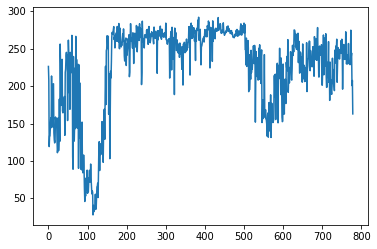

In [9]:
plt.plot(-res)

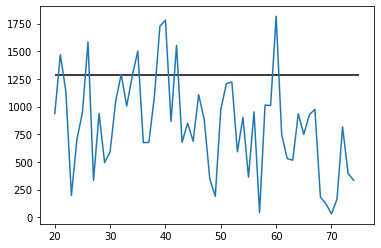

In [43]:
lims = (20, 75)
coefs = np.abs(np.fft.rfft(res)[lims[0]:lims[1]])
plt.plot(coefs)
plt.xticks([i for i in range(0, len(coefs), 10)], labels=[i for i in range(lims[0], lims[1] + 1, 10)])
plt.hlines(y=np.mean(coefs) + 1*np.std(coefs), xmin=0, xmax=len(coefs))

In [38]:
np.mean(coefs)

838.0897078630493

In [39]:
np.std(coefs)

446.3231873045348

In [20]:
z = np.flip(np.argsort(np.fft.rfft(res)[20:75])) + 20
z

array([60, 39, 35, 26, 34, 38, 59, 25, 44, 40, 64, 61, 45, 24, 50, 56, 58,
       48, 54, 49, 30, 65, 68, 27, 71, 57, 70, 62, 74, 36, 28, 29, 33, 69,
       23, 46, 63, 73, 55, 37, 31, 32, 72, 66, 43, 41, 53, 20, 51, 47, 67,
       22, 52, 21, 42])

In [21]:
60*z/30

array([120.,  78.,  70.,  52.,  68.,  76., 118.,  50.,  88.,  80., 128.,
       122.,  90.,  48., 100., 112., 116.,  96., 108.,  98.,  60., 130.,
       136.,  54., 142., 114., 140., 124., 148.,  72.,  56.,  58.,  66.,
       138.,  46.,  92., 126., 146., 110.,  74.,  62.,  64., 144., 132.,
        86.,  82., 106.,  40., 102.,  94., 134.,  44., 104.,  42.,  84.])

In [5]:
df.to_csv('results2.csv')

In [25]:
from remote.utils import coordinate_grid

video = NumpyVideo('data/validation/1.mp4')
frame = video.frames[100, :, :, video.channel_map['r']]
roi_detector = RedThresholdROI()
bpme = ParaboloidHRE(roi_detector)
bpme.fit(video)
roi = bpme.roi_detector.transform(video)[300]
w, h = frame.shape
frame_idxs = coordinate_grid(h, w)
roi = frame_idxs[roi]
cx = np.mean(roi[:, 1], dtype=np.int)
cy = np.mean(roi[:, 0], dtype=np.int)
centroid = np.array([cy, cx])
roi = np.insert(roi, 0, centroid, axis=0)
x_min, x_max = roi[:, 1].min(), roi[:, 1].max()
y_min, y_max = roi[:, 0].min(), roi[:, 0].max()

In [49]:
X = roi[:,1] - cx
Y = roi[:,0] - cy

In [50]:
R = np.sqrt(np.square(X) + np.square(Y))
T = np.arctan2(Y, X)

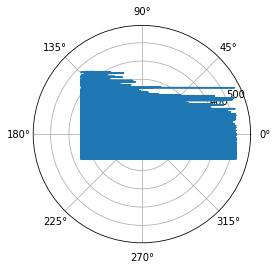

In [51]:
plt.polar(T, R)

In [64]:
frame.shape

(480, 848)

In [65]:
roi.shape

(200016, 2)

In [66]:
roi[T - degree_to_rad(45) == 0]

array([[138, 334],
       [139, 335],
       [140, 336],
       [141, 337],
       [142, 338],
       [143, 339],
       [144, 340],
       [145, 341],
       [146, 342],
       [147, 343],
       [148, 344],
       [149, 345],
       [150, 346],
       [152, 348],
       [153, 349],
       [154, 350],
       [155, 351],
       [156, 352],
       [157, 353],
       [158, 354],
       [159, 355],
       [160, 356],
       [161, 357],
       [162, 358],
       [163, 359],
       [164, 360],
       [165, 361],
       [166, 362],
       [167, 363],
       [168, 364],
       [169, 365],
       [170, 366],
       [171, 367],
       [172, 368],
       [173, 369],
       [174, 370],
       [175, 371],
       [176, 372],
       [177, 373],
       [178, 374],
       [179, 375],
       [180, 376],
       [181, 377],
       [182, 378],
       [183, 379],
       [184, 380],
       [185, 381],
       [186, 382],
       [187, 383],
       [188, 384],
       [189, 385],
       [190, 386],
       [191,

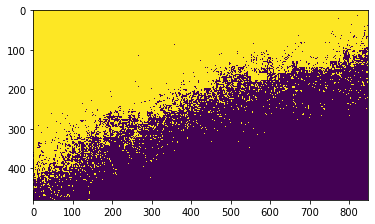

In [53]:
show_region_of_interest(frame, roi)

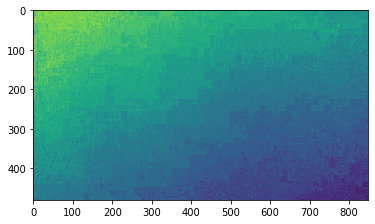

In [54]:
plt.imshow(frame)

In [55]:
import numpy as np
from remote.error_analysis import show_region_of_interest
from remote.utils import degree_to_rad

In [10]:
video.frames

array([], dtype=uint8)

In [11]:
import cv2

In [13]:
vid = cv2.VideoCapture('1.mp4')

In [17]:
vid.read()

(False, None)

### Signal Approach

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from remote.readers import NumpyVideo

In [2]:
video = NumpyVideo('data/validation/1.mp4')

In [28]:
def get_central_bounds(x_min, x_max, i, k):
    if i <= k//2:
        return 0, k
    elif i >= x_max - k//2:
        return x_max - k, x_max
    else:
        return i - k//2, i + k//2
    return lower, upper

In [38]:
n = len(video.frames)
k = 100
for i in range(n):
    lower, upper = get_central_bounds(0, n, i, k)
    means = video.frames[lower:upper, :, :, :].reshape(upper-lower, -1, 3).mean(axis=1).mean(axis=0)
    stds = video.frames[lower:upper, :, :, :].reshape(upper-lower, -1, 3).std(axis=1).std(axis=0)
    break

In [34]:
cube.shape

(100, 407040, 3)

In [37]:
cube.mean(axis=1).mean(axis=0).shape

(3,)

In [32]:
lower - upper

-100

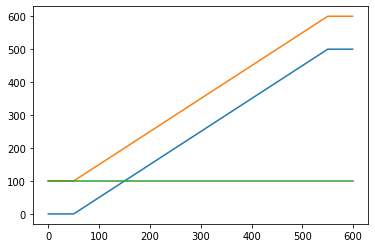

In [26]:
x = np.arange(0, 600)
y = np.array([get_central_average(0, 600, i, k=100) for i in x])
plt.plot(x, y, y.T[1] - y.T[0])

array([  0, 100])


## Custom Approach

In [122]:
import pandas as pd

df = pd.read_csv('data/validation/meta.csv')
df

//anaconda3/envs/covid/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,file,mode,light_source,spo2,bpm
0,1.mp4,transmission,white-bulb,93.0,79.0
1,2.mp4,transmission,white-bulb,94.0,86.0
2,3.mp4,transmission,white-bulb,92.0,83.0
3,israel.MOV,transmission,yellow-lamp,NaN,71.0
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0
5,israel3.MOV,reflection,white-led,NaN,82.5
6,israel4.MOV,reflection,white-led,NaN,82.5
7,israel5.MOV,transmission,white-bulb,NaN,82.5
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0
9,sandra2.mp4,transmission,yellow-bulb,93.0,76.0


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from remote.readers import NumpyVideo

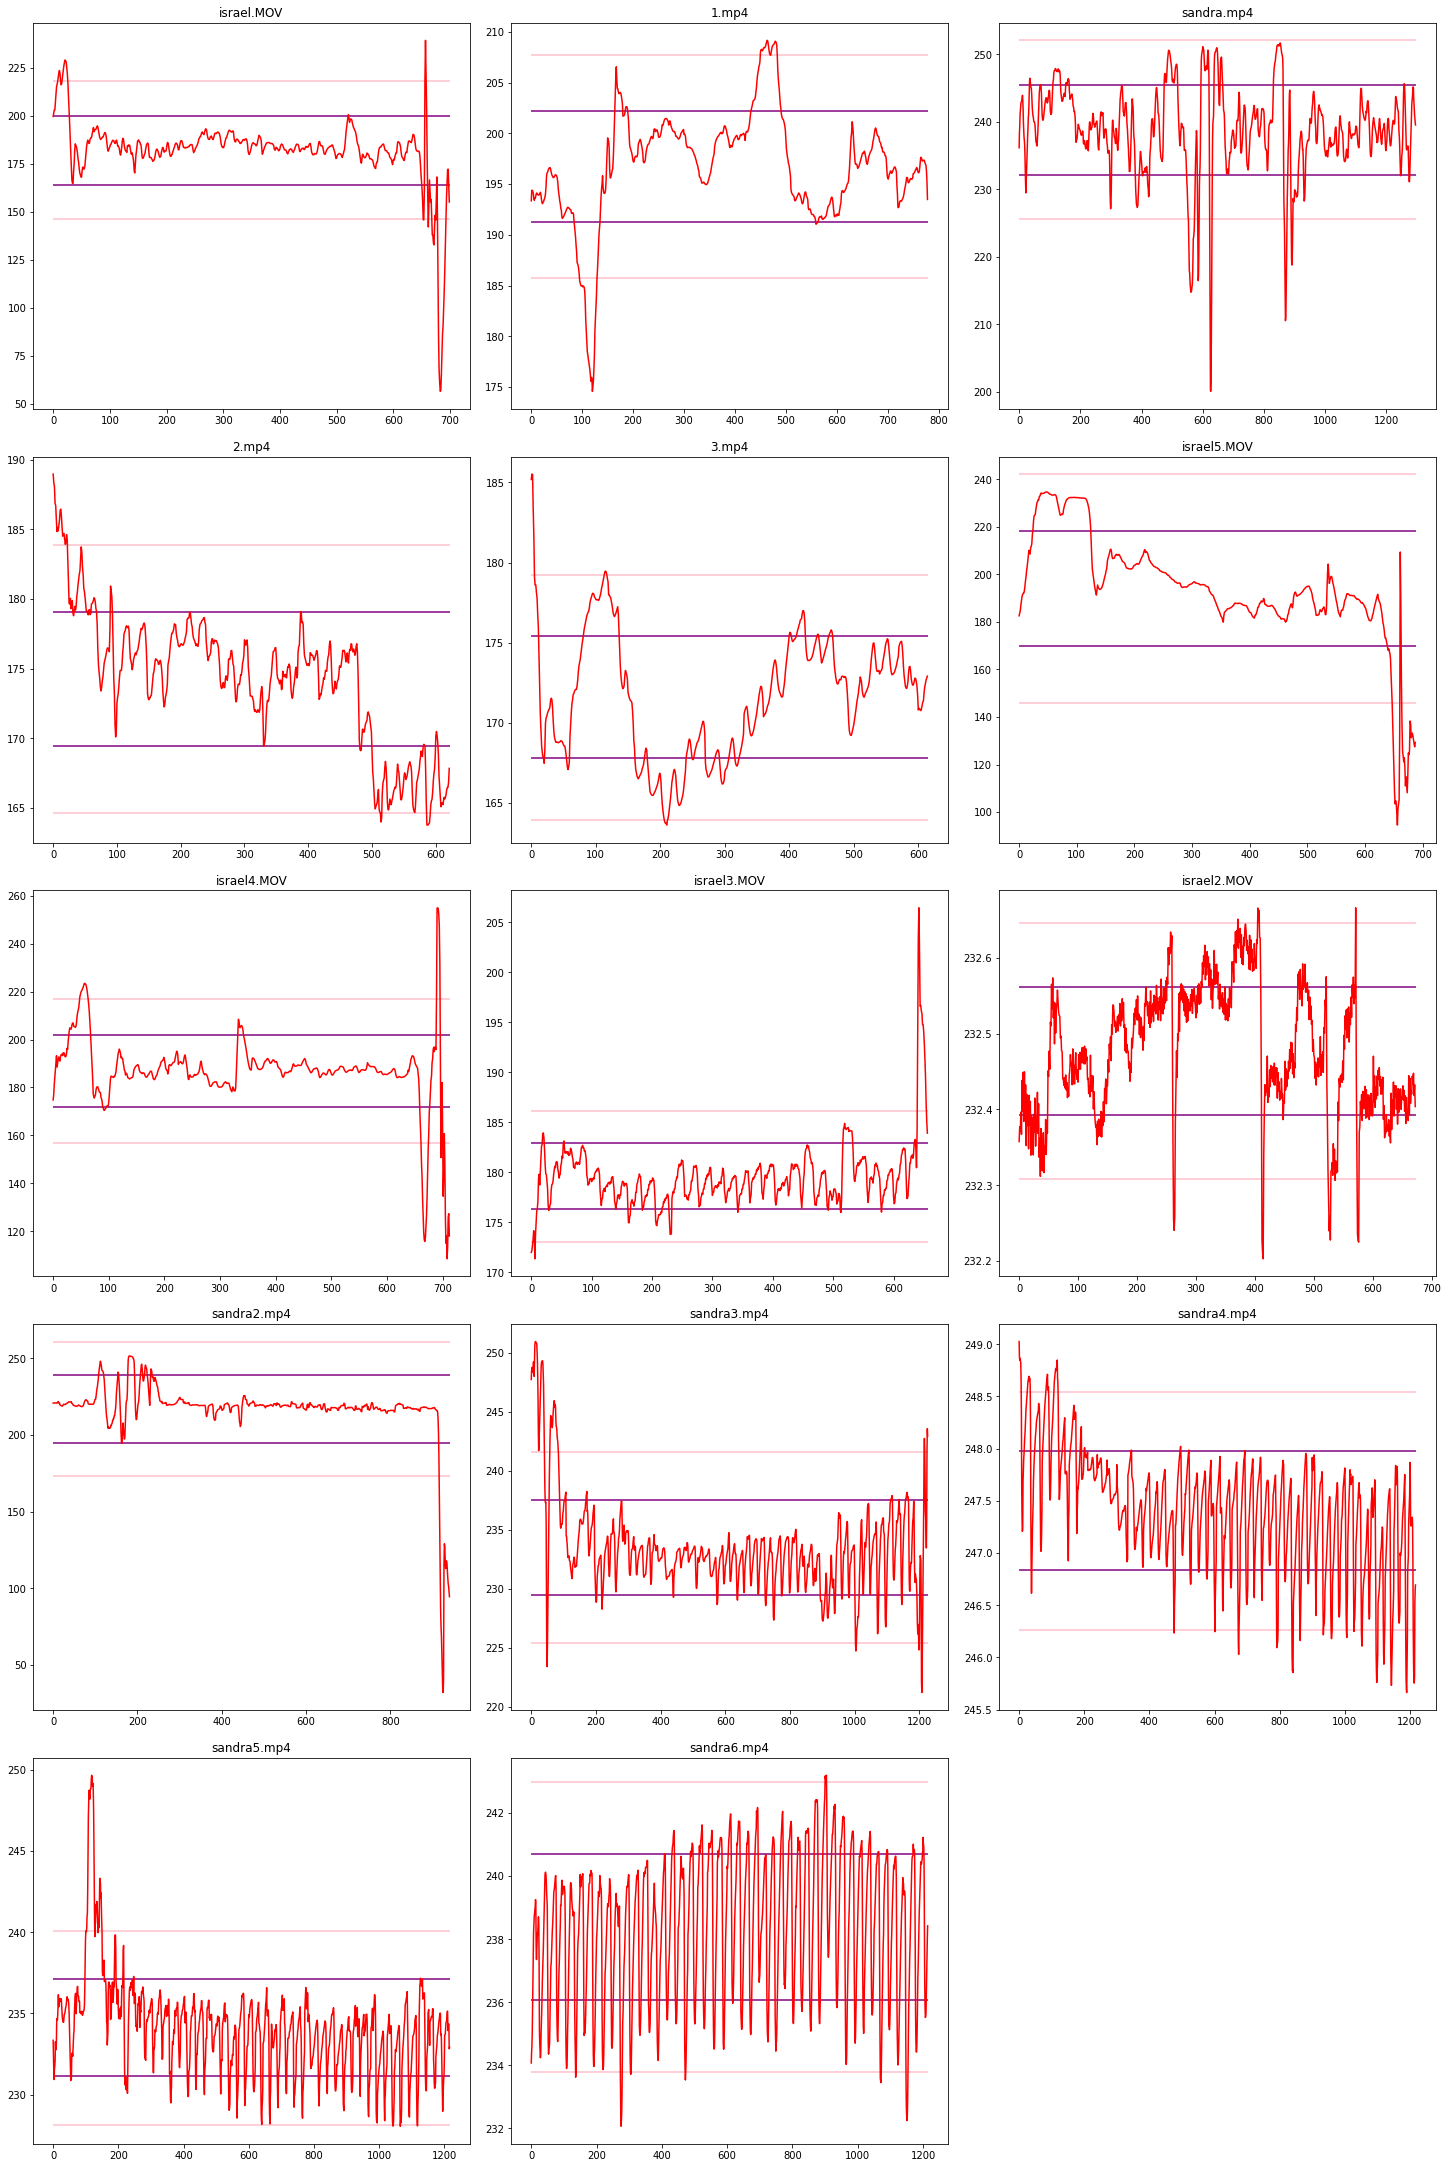

In [3]:
files = os.listdir('data/validation/')
files.remove('meta.csv')
figsize = (20, 30)
cols = 3
rows = len(files) // cols + 1

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(files))
channel = 'r'
for ax, file in zip(axs, files):
    ax.set_title(file)
    video = NumpyVideo(os.path.join('data/validation', file))
    frames = video.frames[:, :, :, video.channel_map[channel]]
    signal = frames.reshape(len(frames), -1).mean(axis=1)
    m, s = np.mean(signal), np.std(signal)
    ax.plot(signal, c=channel)
    ax.hlines(m + s, 0, len(frames), colors='purple')
    ax.hlines(m - s, 0, len(frames), colors='purple')
    ax.hlines(m + 2*s, 0, len(frames), colors='pink')
    ax.hlines(m - 2*s, 0, len(frames), colors='pink')

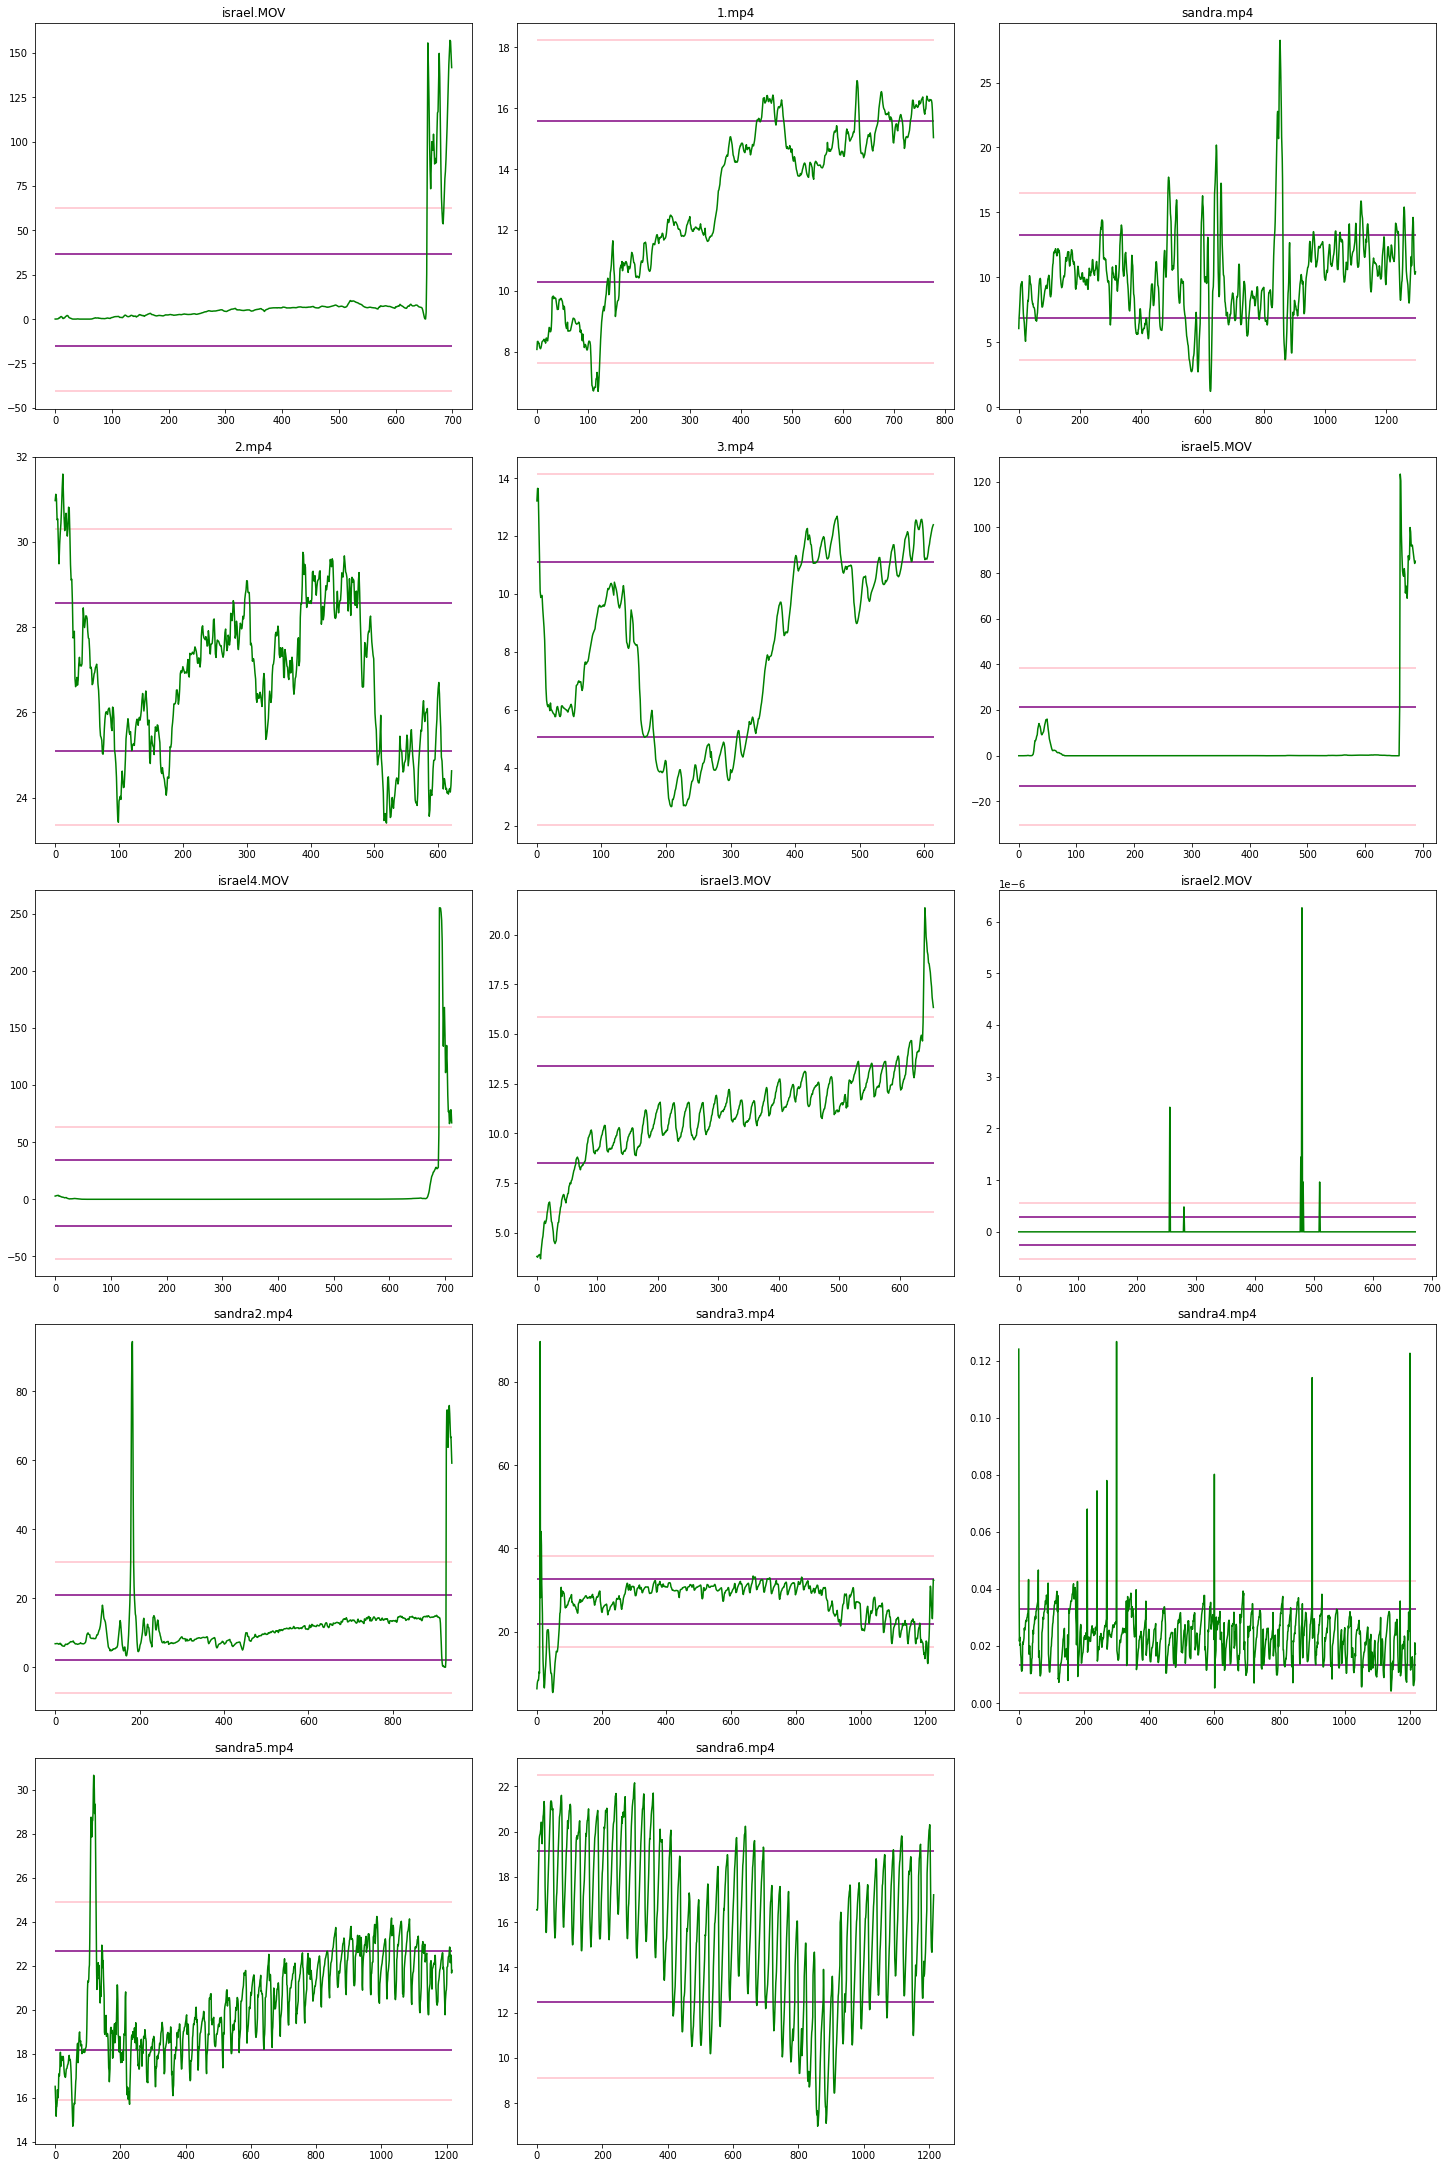

In [5]:
files = os.listdir('data/validation/')
files.remove('meta.csv')
figsize = (20, 30)
cols = 3
rows = len(files) // cols + 1

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(files))
channel = 'g'
for ax, file in zip(axs, files):
    ax.set_title(file)
    video = NumpyVideo(os.path.join('data/validation', file))
    frames = video.frames[:, :, :, video.channel_map[channel]]
    signal = frames.reshape(len(frames), -1).mean(axis=1)
    m, s = np.mean(signal), np.std(signal)
    ax.plot(signal, c=channel)
    ax.hlines(m + s, 0, len(frames), colors='purple')
    ax.hlines(m - s, 0, len(frames), colors='purple')
    ax.hlines(m + 2*s, 0, len(frames), colors='pink')
    ax.hlines(m - 2*s, 0, len(frames), colors='pink')

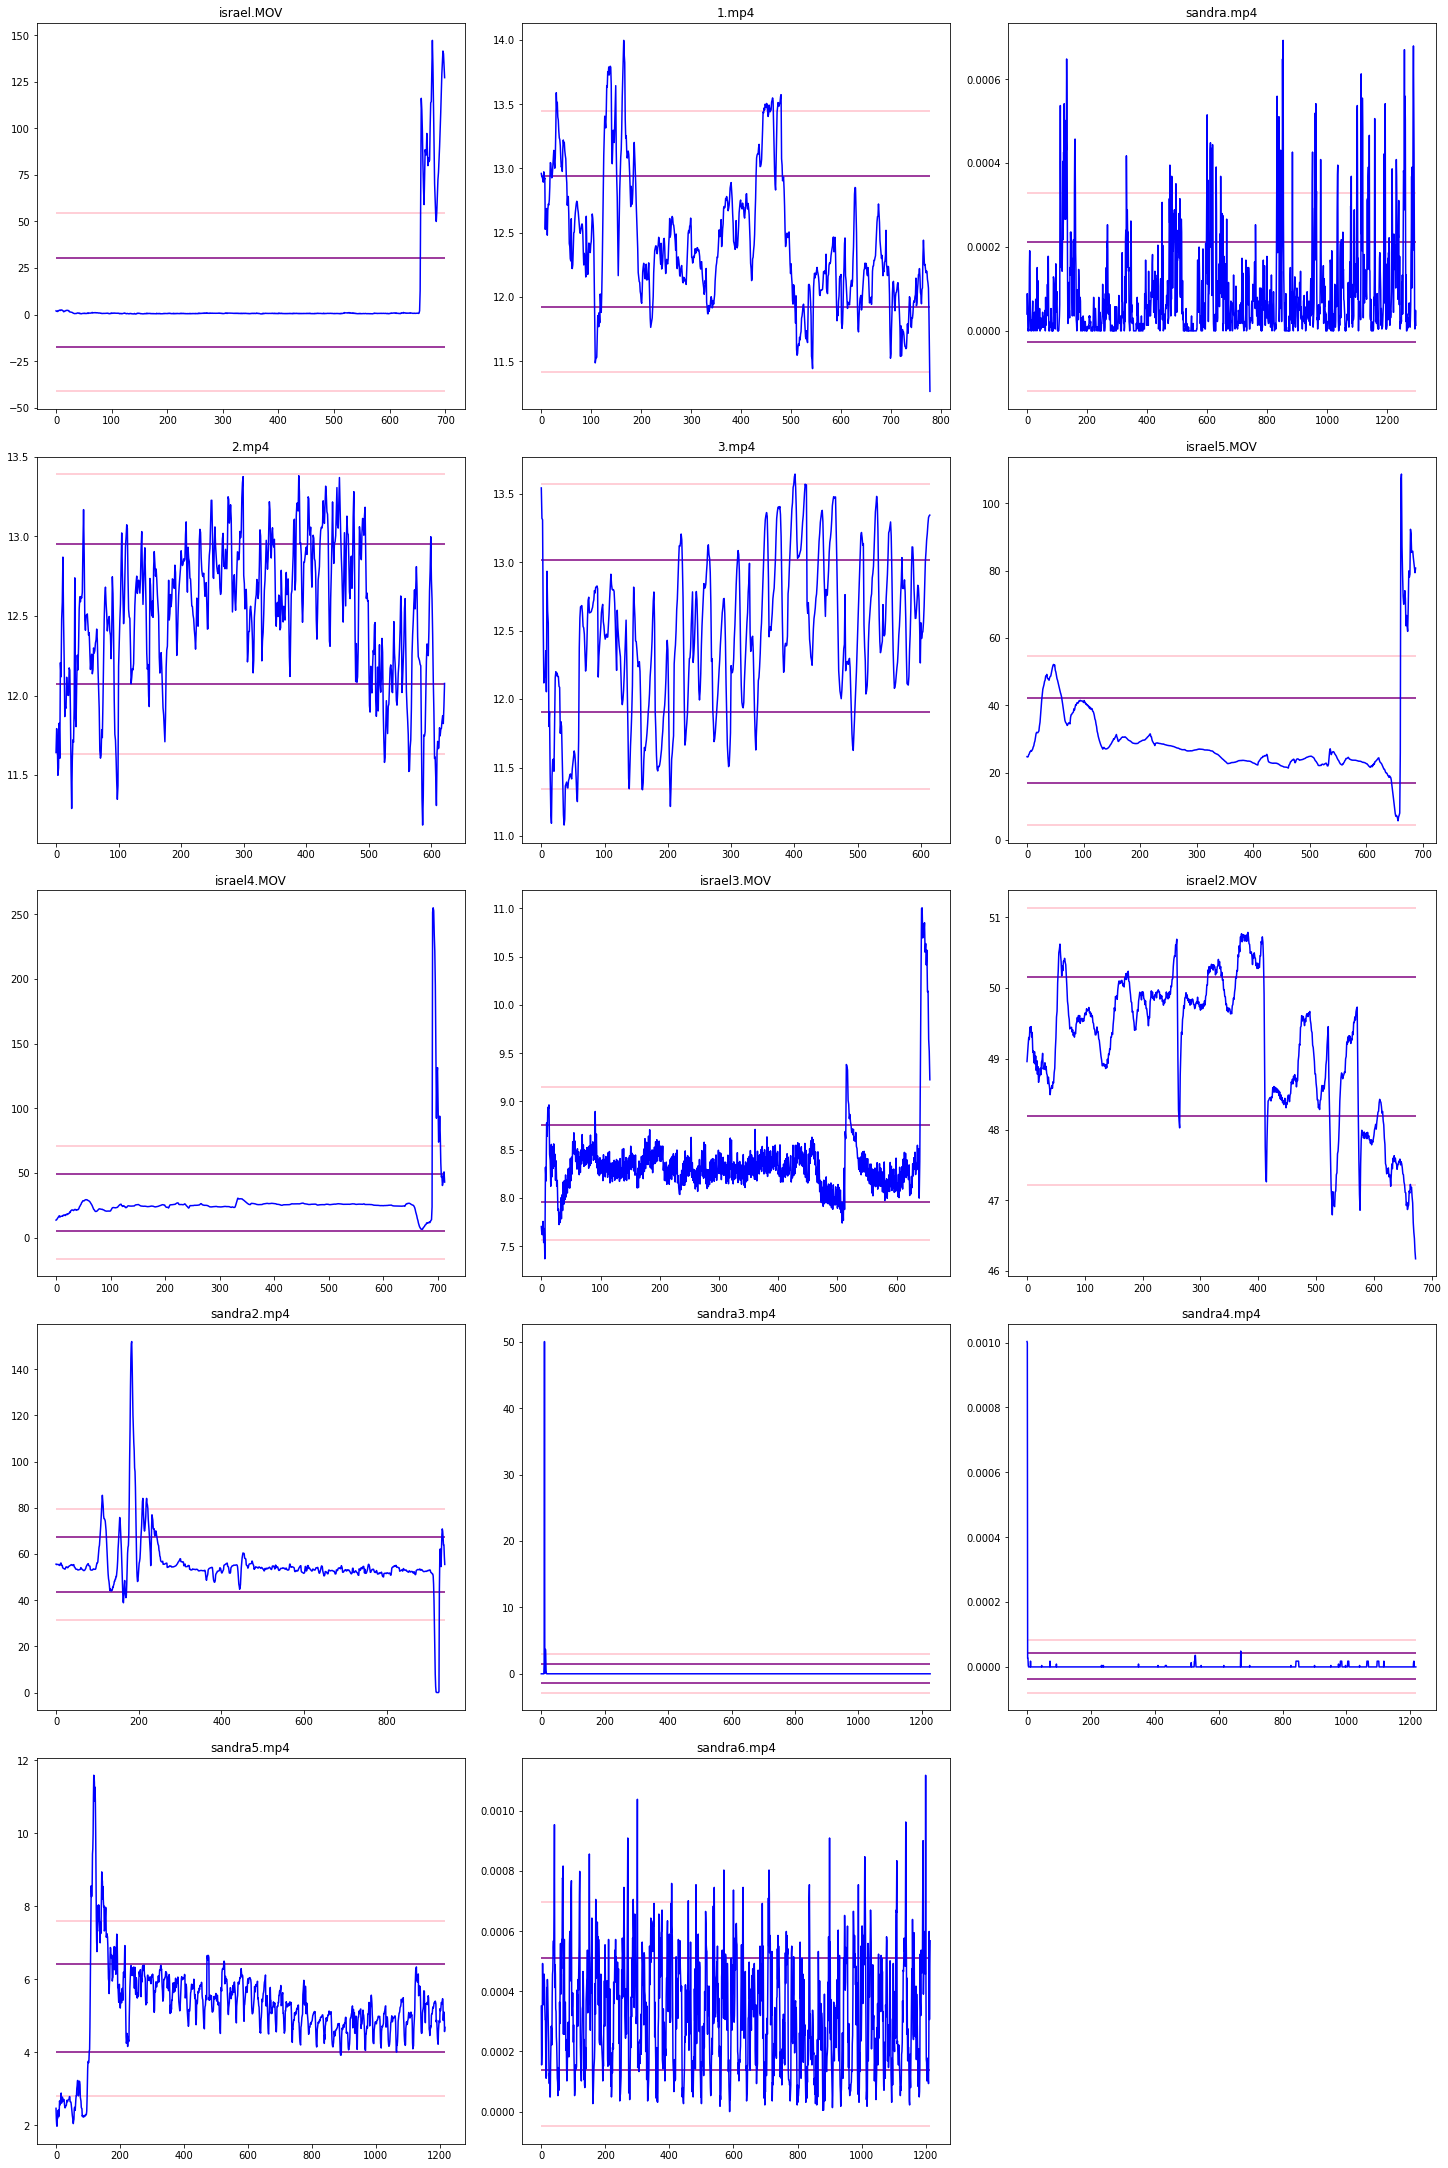

In [6]:
files = os.listdir('data/validation/')
files.remove('meta.csv')
figsize = (20, 30)
cols = 3
rows = len(files) // cols + 1

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(files))
channel = 'b'
for ax, file in zip(axs, files):
    ax.set_title(file)
    video = NumpyVideo(os.path.join('data/validation', file))
    frames = video.frames[:, :, :, video.channel_map[channel]]
    signal = frames.reshape(len(frames), -1).mean(axis=1)
    m, s = np.mean(signal), np.std(signal)
    ax.plot(signal, c=channel)
    ax.hlines(m + s, 0, len(frames), colors='purple')
    ax.hlines(m - s, 0, len(frames), colors='purple')
    ax.hlines(m + 2*s, 0, len(frames), colors='pink')
    ax.hlines(m - 2*s, 0, len(frames), colors='pink')

In [85]:
from scipy import signal

In [83]:
def plot_signal_and_spectrum(s):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
    ax = ax.flat
    ax[0].plot(s)
    f = np.abs(np.fft.rfft(s))
    ax[1].plot(f)

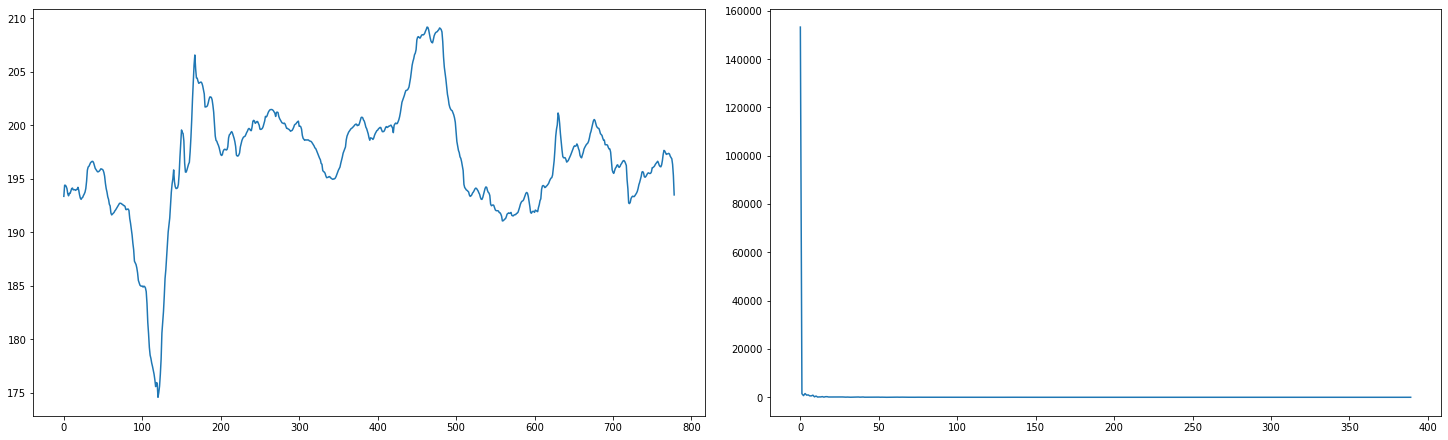

In [126]:
video = NumpyVideo(os.path.join('data/validation', '1.mp4'))
frames = video.frames[:, :, :, video.channel_map['r']]
s = frames.reshape(len(frames), -1).mean(axis=1)
plot_signal_and_spectrum(s)

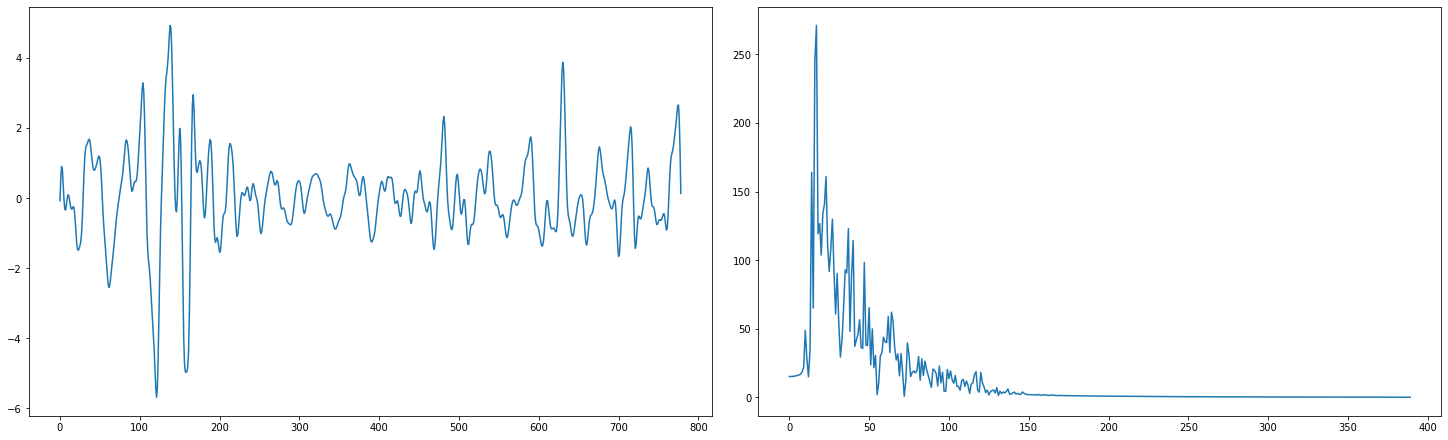

In [127]:
b, a = signal.butter(5, [0.5/(video.fps/2), 5/(video.fps/2)], 'bandpass')
output = signal.filtfilt(b, a, s)
plot_signal_and_spectrum(output)

In [130]:
np.argsort(np.abs(np.fft.rfft(output)))

array([389, 388, 387, 386, 385, 384, 383, 382, 381, 380, 379, 378, 377,
       376, 375, 374, 373, 372, 371, 370, 369, 368, 367, 366, 365, 364,
       363, 362, 361, 360, 359, 358, 357, 356, 355, 354, 353, 352, 351,
       350, 349, 348, 347, 346, 345, 344, 343, 342, 341, 340, 339, 338,
       337, 336, 335, 334, 333, 332, 331, 330, 329, 328, 327, 326, 325,
       324, 323, 322, 321, 320, 319, 318, 317, 316, 315, 314, 313, 312,
       311, 310, 309, 308, 307, 306, 305, 304, 303, 302, 301, 300, 299,
       298, 297, 296, 295, 294, 293, 292, 291, 290, 289, 288, 287, 286,
       285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 275, 274, 273,
       272, 271, 270, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260,
       259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 249, 248, 247,
       246, 245, 244, 243, 242, 241, 240, 239, 238, 237, 236, 235, 234,
       233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221,
       220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 20

In [134]:
60*26/(800/30)

58.5

In [116]:
60*17/30

34.0

In [99]:
0.5*60/30

1.0

In [108]:
1200/30

40.0

In [109]:
60*44/40

66.0

In [117]:
60*26/(800/30)

58.5

### Extracting frequency

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from remote.readers import NumpyVideo
from remote.measurement.heart_rate import OptimizedParaboloidHRE, AverageHRE
from remote.measurement.roi import RedThresholdROI, FullChannelROI

In [2]:
def filter_signal(s, fps, order=2, bandpass_range=(0.5, 5)):
    low = bandpass_range[0]/(fps/2)
    upp = bandpass_range[1]/(fps/2)
    b, a = signal.butter(order, [low, upp], 'bandpass')
    return signal.filtfilt(b, a, s)

In [3]:
def extract_frequency_in_hz(s, fps):
    #taken from https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
    w = np.abs(np.fft.fft(s))
    freqs = np.fft.fftfreq(len(w))
    idx = np.argmax(w)
    dominant_freq = freqs[idx]
    return np.abs(dominant_freq * fps)

In [4]:
def hz_to_bpm(f):
    return 60 * f

In [5]:
def plot_signal_and_spectrum(s):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
    ax = ax.flat
    ax[0].plot(s)
    f = np.abs(np.fft.rfft(s))
    ax[1].plot(f)

In [12]:
bpme = AverageHRE(FullChannelROI('r'))

In [13]:
video = NumpyVideo('data/jmg-bulb.mp4')
s = bpme.measure(video, reduce=False)
filtered_signal = filter_signal(s, video.fps)
hz_to_bpm(extract_frequency_in_hz(filtered_signal, video.fps))

88.5541082000011

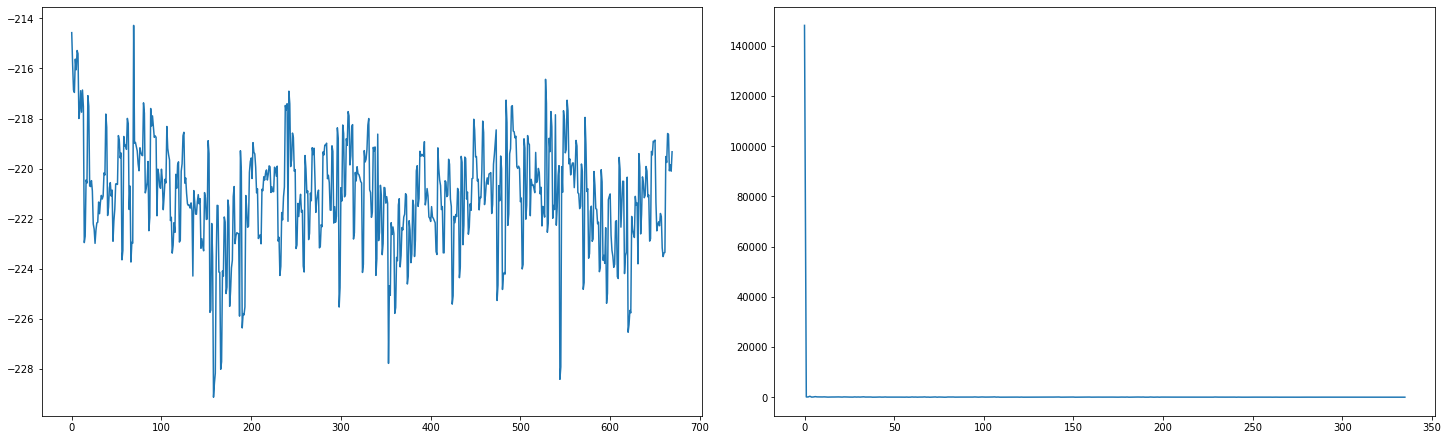

In [14]:
plot_signal_and_spectrum(s)

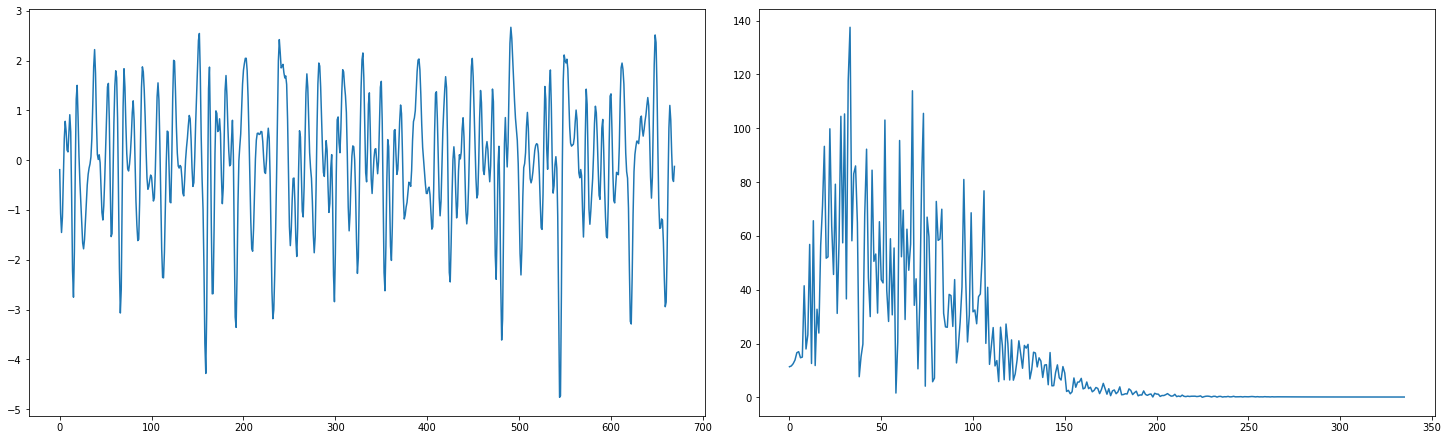

In [15]:
plot_signal_and_spectrum(filtered_signal)

In [76]:
def sinusoidal_regression(s):
    t = np.arange(len(s))/len(s)
    def model_f(t, w0, w1, w2, w3, w4, c, h):
        return w0 + w1*np.sin(1*c*(t-h)*np.pi) + w2*np.sin(2*c*(t-h)*np.pi) + \
                    w3*np.sin(3*c*(t-h)*np.pi) + w4*np.sin(4*c*(t-h)*np.pi)
    
    res = scipy.optimize.curve_fit(model_f, t, s, [7, 7, 3, 1, 1, 2, 0.1], maxfev=100000)
    preds = model_f(t, *res[0])
    mse = np.mean((s - preds)**2)
    return preds, mse

### Check adequate signals

In [84]:
import os

files = os.listdir('data/validation/')
files.remove('meta.csv')

for file in files:
    video = NumpyVideo(f'data/validation/{file}')
    s = AverageHRE(FullChannelROI('r')).measure(video, reduce=False)
    filtered_signal = filter_signal(s, video.fps)
    hz = hz_to_bpm(extract_frequency_in_hz(filtered_signal, video.fps))
    preds, mse = sinusoidal_regression(filtered_signal)
    print(f'File: {file} - MSE: {mse} - Hz: {hz}')

File: israel.MOV - MSE: 77.10732416201182 - Hz: 79.73117791299609
File: 1.mp4 - MSE: 1.4435042301164842 - Hz: 39.288694870642615
File: sandra.mp4 - MSE: 18.55189271841066 - Hz: 52.75646080248953
File: 2.mp4 - MSE: 2.0897318946588315 - Hz: 83.94307308836535
File: 3.mp4 - MSE: 1.0002235374626904 - Hz: 81.97121249085143
File: israel5.MOV - MSE: 37.635281490645234 - Hz: 41.869488712984456
File: israel4.MOV - MSE: 85.62866827044952 - Hz: 42.926181602851
File: israel3.MOV - MSE: 3.6164679216706275 - Hz: 57.54722715289575
File: israel2.MOV - MSE: 0.0019977364442157067 - Hz: 40.12770943060096
File: sandra2.mp4 - MSE: 89.11668134407581 - Hz: 57.38039375701315
File: sandra3.mp4 - MSE: 4.545853622111553 - Hz: 82.13552361396303
File: sandra4.mp4 - MSE: 0.17157922774035697 - Hz: 75.35836267128704
File: sandra5.mp4 - MSE: 3.265894535230166 - Hz: 70.9750026697773
File: sandra6.mp4 - MSE: 4.572022439702034 - Hz: 63.688956521452916


In [85]:
import pandas as pd

pd.read_csv('data/validation/meta.csv')

,file,mode,light_source,spo2,bpm
0,1.mp4,transmission,white-bulb,93.0,79.0
1,2.mp4,transmission,white-bulb,94.0,86.0
2,3.mp4,transmission,white-bulb,92.0,83.0
3,israel.MOV,transmission,yellow-lamp,NaN,71.0
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0
5,israel3.MOV,reflection,white-led,NaN,82.5
6,israel4.MOV,reflection,white-led,NaN,82.5
7,israel5.MOV,transmission,white-bulb,NaN,82.5
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0
9,sandra2.mp4,transmission,yellow-bulb,93.0,76.0


In [88]:
video = NumpyVideo('data/jmg-lamp.mp4')
s = AverageHRE(FullChannelROI('r')).measure(video, reduce=False)
filtered_signal = filter_signal(s, video.fps)
hz = hz_to_bpm(extract_frequency_in_hz(filtered_signal, video.fps))
preds, mse = sinusoidal_regression(filtered_signal)

In [89]:
print(mse)
print(hz)

10.567487394263784
81.28348270103945


In [77]:
r = sinusoidal_regression(filtered_signal)

In [80]:
r[1]

1.5232716353904012

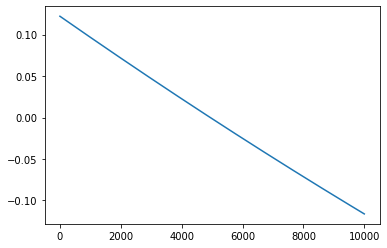

In [70]:
plt.plot(r[0])

In [62]:
np.mean((preds - sine)**2)

0.48469527348131514

## Custom Algorithm

1. Crop recording errors to time interval `[s, T-s]`
2. Generate **ROI** based on *time-difference* selection
3. Generate signal based on intensity of color channel
4. Filter signal with a bandpass filter between `0.8Hz` and `3Hz``
5. Reduce signal to BPM using **FFT**

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from remote.readers import NumpyVideo

In [2]:
def crop_recording_errors(frames, crop_from_start=120, crop_from_end=120):
    return frames[crop_from_start:-crop_from_end]

In [3]:
def conv_2d(frames, kernel):
    n, h, w = frames.shape
    kh, kw = kernel.shape
    frames = frames.reshape((n, h, w, 1)).astype(np.float32)
    kernel = kernel.reshape(kh, kw, 1, 1)
    conv_op = tf.keras.layers.Conv2D(filters=1, kernel_size=(kh, kw), use_bias=False, input_shape=(h, w, 1),
                                     kernel_initializer=tf.keras.initializers.Constant(kernel))
    return conv_op(frames).numpy().reshape((n, h - kh + 1, w - kw + 1))
    

def temporal_difference_roi(frames, fps, cumulative_period=3, kernel_size=(50, 50)):
    frames = frames.mean(axis=-1)
    roi = np.zeros_like(frames)
    td = np.abs(frames[:-1] - frames[1:])
    td_cum = td.cumsum(axis=0)
    cum_frames = int(fps*cumulative_period)
    td_sum = np.array([td_cum[i + cum_frames] - td_cum[i] for i in range(len(td_cum) - cum_frames)])
    kernel = np.ones(kernel_size) * (1 / (np.prod(kernel_size)))
    convs = conv_2d(td_sum, kernel)
    argmaxes = convs.reshape(len(convs), -1).argmax(axis=1)
    argmax_coords = np.array([(a // convs.shape[-1], a % convs.shape[-1]) for a in argmaxes])
    for i, (y, x) in enumerate(argmax_coords):
        roi[i, y:y+kernel_size[0], x:x+kernel_size[1]] = 1
    roi = roi.astype(np.bool)
    return roi[:i+1]

In [4]:
def generate_signal(frames, roi, channel):
    s = np.zeros(len(roi))
    frames = frames[:, :, :, channel]
    for i, r in enumerate(roi):
        s[i] = frames[i, r].mean()
    return s

In [5]:
def filter_signal(s, fps, order=2, bandpass_range=(0.8, 3)):
    low = bandpass_range[0]/(fps/2)
    upp = bandpass_range[1]/(fps/2)
    b, a = signal.butter(order, [low, upp], 'bandpass')
    return signal.filtfilt(b, a, s)

In [6]:
def extract_frequency_in_bpm(s, fps):
    #taken from https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
    w = np.abs(np.fft.fft(s))
    freqs = np.fft.fftfreq(len(w))
    idx = np.argmax(w)
    dominant_freq = freqs[idx]
    return 60*np.abs(dominant_freq * fps)

In [7]:
def measure_bpm(video):
    frames = crop_recording_errors(video.frames)
    roi = temporal_difference_roi(frames, video.fps)
    s = generate_signal(frames, roi, video.channel_map['r'])
    filtered_signal = filter_signal(s, video.fps)
    return extract_frequency_in_bpm(filtered_signal, video.fps)

In [8]:
def get_signals(video, channel='r'):
    original_signal = video.frames[:, :, :, video.channel_map[channel]].reshape(len(video.frames), -1).mean(axis=-1)
    frames = crop_recording_errors(video.frames)
    cropped_signal = frames[:, :, :, video.channel_map['r']].reshape(len(frames), -1).mean(axis=-1)
    roi = temporal_difference_roi(frames, video.fps)
    s = generate_signal(frames, roi, video.channel_map['r'])
    filtered_signal = filter_signal(s, video.fps)
    return original_signal, cropped_signal, s, filtered_signal

In [9]:
meta = pd.read_csv('data/validation/meta.csv')
meta.head()

,file,mode,light_source,spo2,bpm
0,1.mp4,transmission,white-bulb,93.0,79.0
1,2.mp4,transmission,white-bulb,94.0,86.0
2,3.mp4,transmission,white-bulb,92.0,83.0
3,israel.MOV,transmission,yellow-lamp,NaN,71.0
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0


In [10]:
pbpm = []
for file in meta.file:
    print(f'Processing {file}')
    video = NumpyVideo(os.path.join('data/validation', file))
    pbpm.append(measure_bpm(video))

Processing 1.mp4
Processing 2.mp4
Processing 3.mp4
Processing israel.MOV
Processing israel2.MOV
Processing israel3.MOV
Processing israel4.MOV
Processing israel5.MOV
Processing sandra.mp4
Processing sandra2.mp4
Processing sandra3.mp4
Processing sandra4.mp4
Processing sandra5.mp4
Processing sandra6.mp4


In [11]:
meta['predicted_bpm'] = pbpm
meta['percent_error'] = np.abs(meta.predicted_bpm - meta.bpm)/meta.bpm
meta

,file,mode,light_source,spo2,bpm,predicted_bpm,percent_error
0,1.mp4,transmission,white-bulb,93.0,79.0,88.409881,0.119112
1,2.mp4,transmission,white-bulb,94.0,86.0,80.431768,0.064747
2,3.mp4,transmission,white-bulb,92.0,83.0,82.414467,0.007055
3,israel.MOV,transmission,yellow-lamp,NaN,71.0,78.065320,0.099512
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0,94.757714,0.334616
5,israel3.MOV,reflection,white-led,NaN,82.5,77.318054,0.062811
6,israel4.MOV,reflection,white-led,NaN,82.5,47.130224,0.428725
7,israel5.MOV,transmission,white-bulb,NaN,82.5,65.560348,0.205329
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0,89.404869,0.334401
9,sandra2.mp4,transmission,yellow-bulb,93.0,76.0,55.968579,0.263571


In [12]:
def get_spectral_amplitude_average(file):
    video = NumpyVideo(os.path.join('data/validation', file))
    a, b, c, d = get_signals(video)
    f = np.abs(np.fft.rfft(d))
    return np.mean(f[f > 0])

In [13]:
meta['spectral_amplitude'] = [get_spectral_amplitude_average(file) for file in meta.file]

In [14]:
meta['error_state'] = ['high' if e > 0.15 else 'low' for e in meta.percent_error]

In [15]:
!pip install seaborn

     |████████████████████████████████| 215 kB 393 kB/s eta 0:00:01


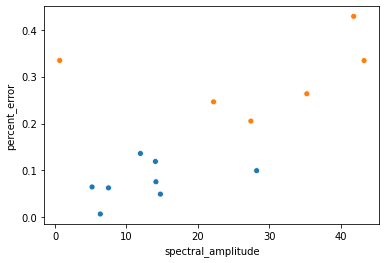

In [20]:
import seaborn as sns

sns.scatterplot(x=meta.spectral_amplitude, y=meta.percent_error, hue=meta.error_state, legend=False)

In [21]:
meta

,file,mode,light_source,spo2,bpm,predicted_bpm,percent_error,spectral_amplitude,error_state
0,1.mp4,transmission,white-bulb,93.0,79.0,88.409881,0.119112,14.050668,low
1,2.mp4,transmission,white-bulb,94.0,86.0,80.431768,0.064747,5.183850,low
2,3.mp4,transmission,white-bulb,92.0,83.0,82.414467,0.007055,6.339431,low
3,israel.MOV,transmission,yellow-lamp,NaN,71.0,78.065320,0.099512,28.217370,low
4,israel2.MOV,transmission,yellow-lamp,NaN,71.0,94.757714,0.334616,0.654446,high
5,israel3.MOV,reflection,white-led,NaN,82.5,77.318054,0.062811,7.481088,low
6,israel4.MOV,reflection,white-led,NaN,82.5,47.130224,0.428725,41.795678,high
7,israel5.MOV,transmission,white-bulb,NaN,82.5,65.560348,0.205329,27.409796,high
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0,89.404869,0.334401,43.249825,high
9,sandra2.mp4,transmission,yellow-bulb,93.0,76.0,55.968579,0.263571,35.239928,high


In [22]:
def plot_signals_of_files(files, figsize=(20, 40)):
    fig, ax = plt.subplots(len(files), 4, figsize=figsize)
    for i, file in enumerate(files):
        video = NumpyVideo(os.path.join('data/validation', file))
        a, b, c, d = get_signals(video)
        ax[i][0].plot(a)
        ax[i][0].set_title(f'{file} - Original')
        ax[i][1].plot(b)
        ax[i][1].set_title(f'{file} - Cropped')
        ax[i][2].plot(c)
        ax[i][2].set_title(f'{file} - With ROI')
        ax[i][3].plot(d)
        ax[i][3].set_title(f'{file} - Filtered')

In [23]:
def plot_signal_and_spectrum(video):
    a, b, c, d = get_signals(video)
    fig, ax = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
    ax = ax.flat
    ax[0].plot(np.abs(np.fft.rfft(a)[1:]))
    ax[1].plot(np.abs(np.fft.rfft(b)[1:]))
    ax[2].plot(np.abs(np.fft.rfft(c)[1:]))
    f = np.abs(np.fft.rfft(d))
    #f = MinMaxScaler().fit_transform(f.reshape(-1, 1)).flatten()
    print(np.std(f))
    ax[3].plot(f)

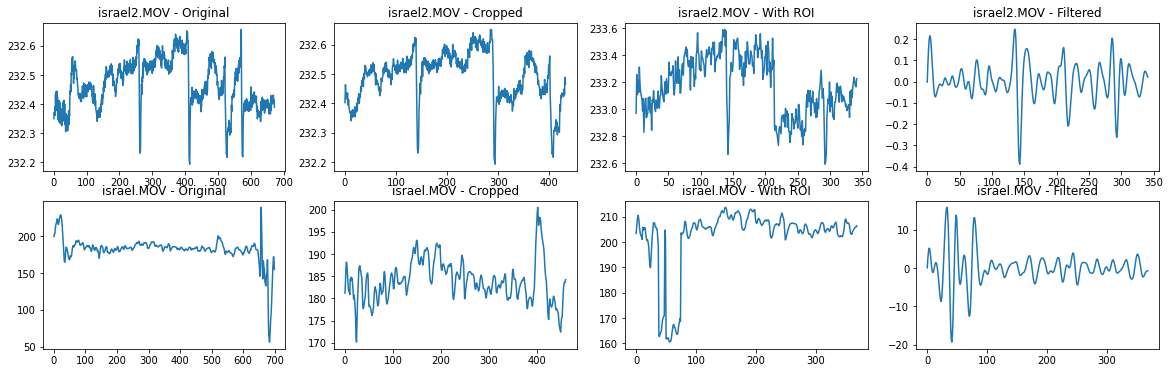

In [26]:
plot_signals_of_files(['israel2.MOV', 'israel.MOV'], figsize=(20, 6))

1.4736389909773602


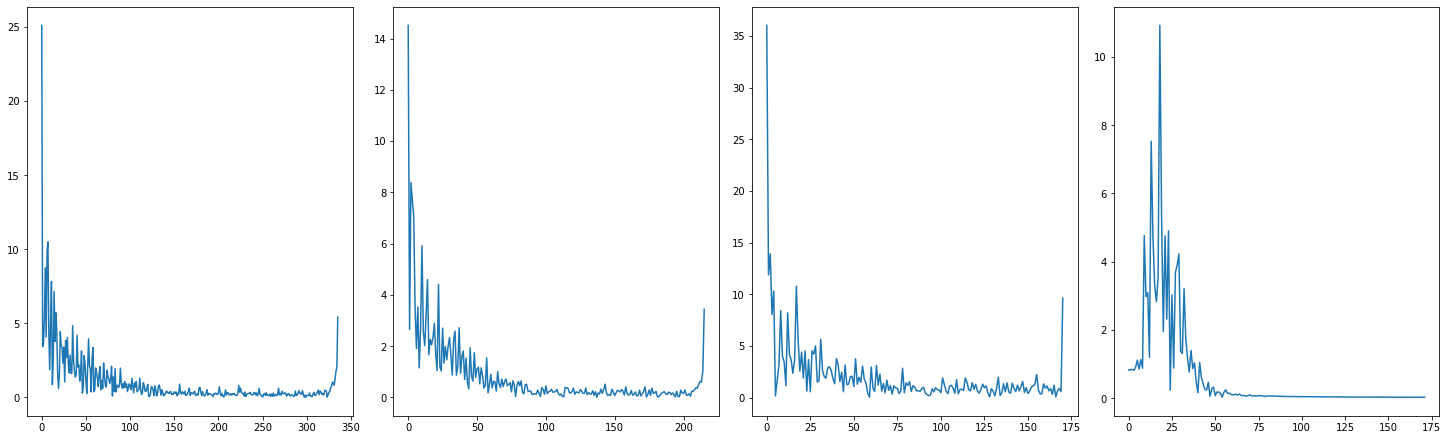

In [24]:
plot_signal_and_spectrum(NumpyVideo(os.path.join('data/validation', 'israel2.MOV')))

In [ ]:
worst_results = meta[meta.percent_error > 0.15].file
worst_results

In [ ]:
plot_signals_of_files(worst_results)

In [ ]:
plot_signals_of_files(meta[meta.percent_error <= 0.15].file)

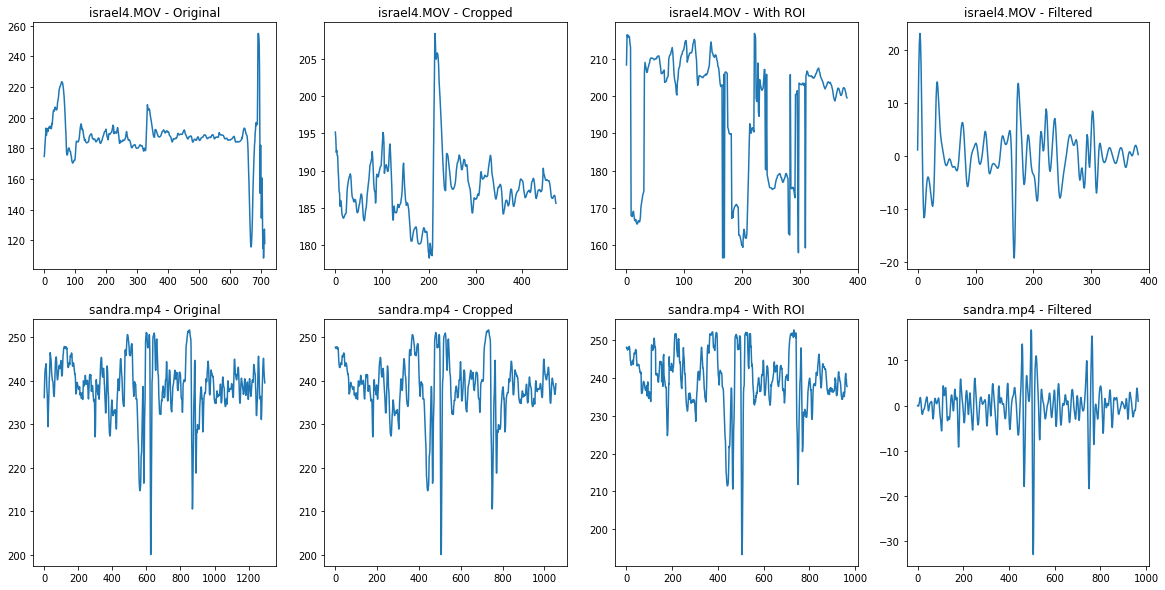

In [17]:
plot_signals_of_files(['israel4.MOV', 'sandra.mp4'], figsize=(20, 10))

In [19]:
meta = pd.read_csv('data/validation/meta.csv')
meta[meta.file.isin(['israel4.MOV', 'sandra.mp4'])]

,file,mode,light_source,spo2,bpm
6,israel4.MOV,reflection,white-led,NaN,82.5
8,sandra.mp4,transmission,yellow-bulb,99.0,67.0


In [20]:
print(measure_bpm(NumpyVideo(os.path.join('data/validation', 'israel4.MOV'))))
print(measure_bpm(NumpyVideo(os.path.join('data/validation', 'sandra.mp4'))))

47.130224026536446
89.40486851915846


In [35]:
!pip install sklearn

  Using cached scikit_learn-0.22.2.post1-cp36-cp36m-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=7735dcec77a35bbb4c784347da286870c54a7c8eed72316fb49c10c3c50e0488
  Stored in directory: /Users/juangutierrez/Library/Caches/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [37]:
from sklearn.preprocessing import MinMaxScaler

90.00190369840014


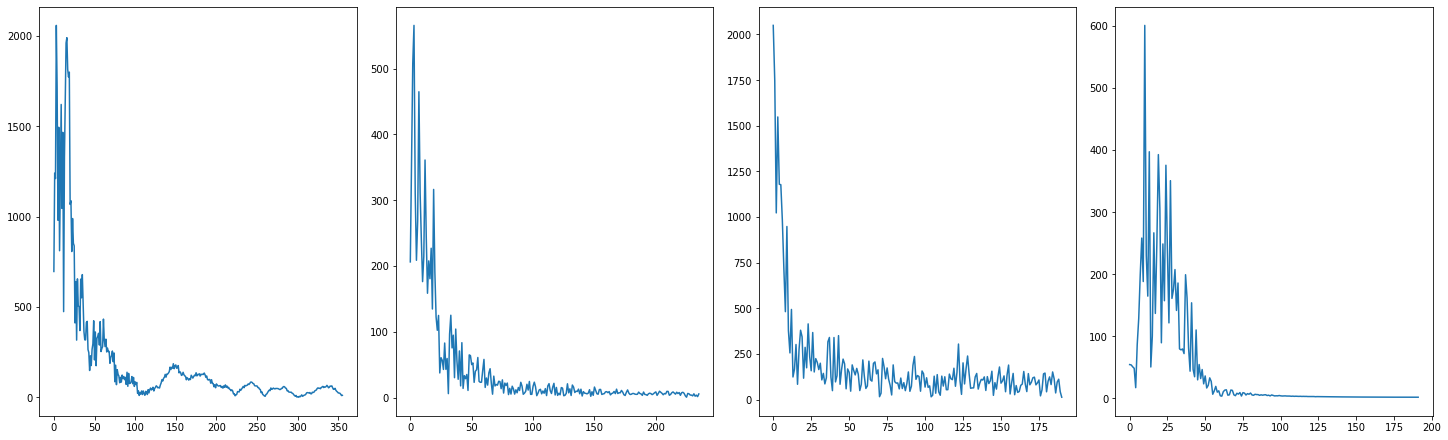

In [47]:
plot_signal_and_spectrum(NumpyVideo(os.path.join('data/validation', 'israel4.MOV')))

133.63594514821384


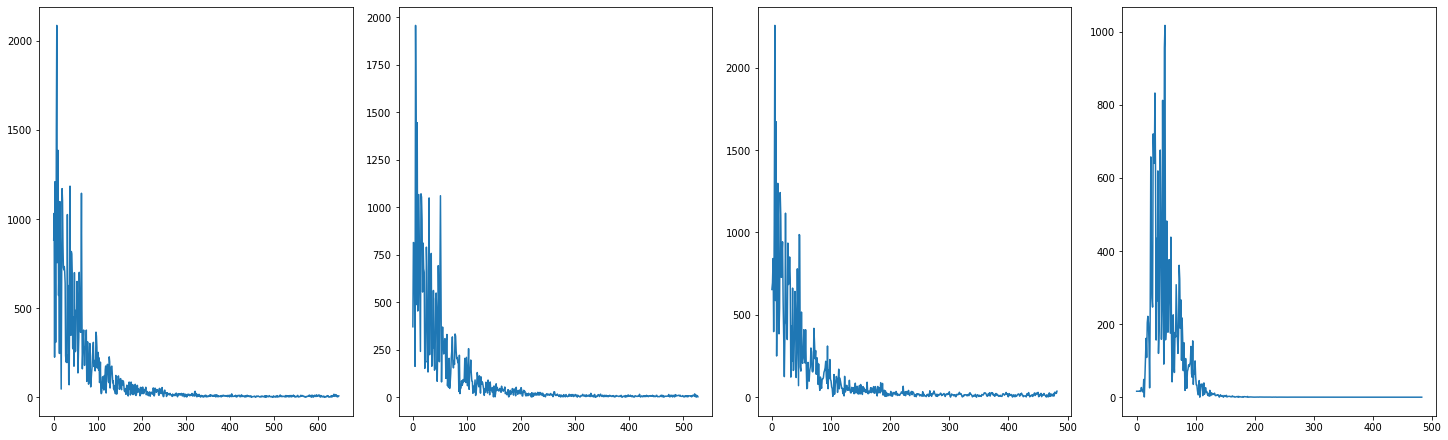

In [48]:
plot_signal_and_spectrum(NumpyVideo(os.path.join('data/validation', 'sandra.mp4')))

17.615631589158543


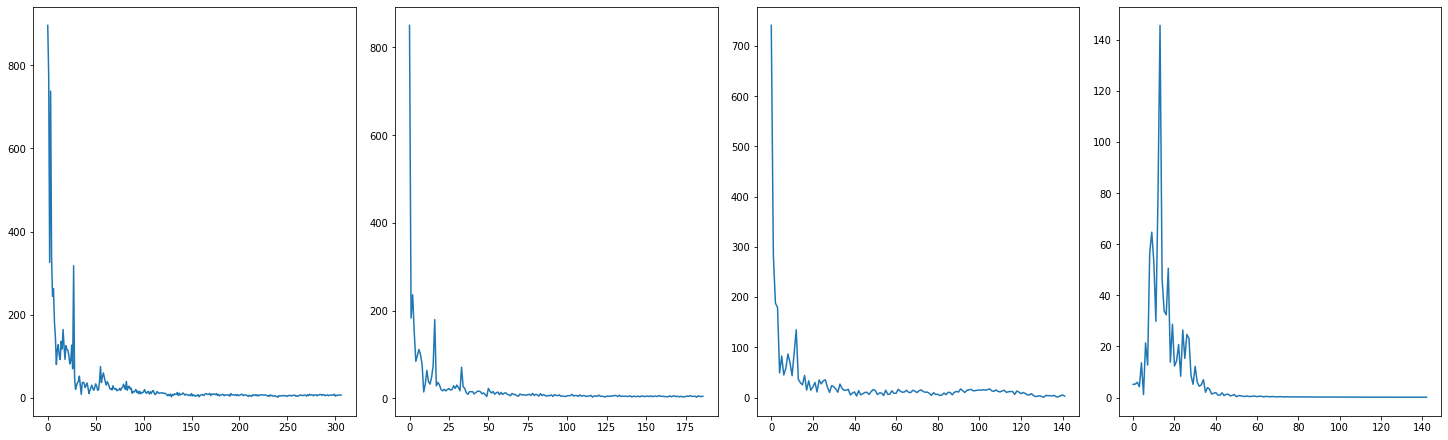

In [49]:
plot_signal_and_spectrum(NumpyVideo(os.path.join('data/validation', '3.mp4')))

16.652721583509543


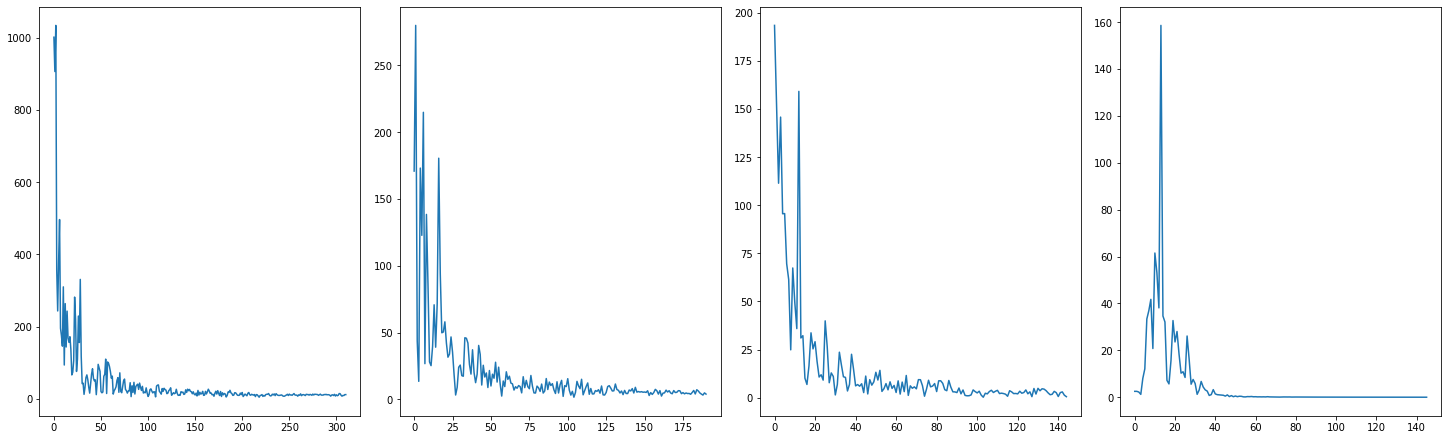

In [50]:
plot_signal_and_spectrum(NumpyVideo(os.path.join('data/validation', '2.mp4')))